# Use Glauber + Pythia for particle production - an AA event generator

In [1]:
from __future__ import print_function

import fastjet as fj
import fjcontrib
import fjext

import os
import sys
import argparse
import numpy as np
import pandas as pd
import uproot

from tqdm.notebook import tqdm

from heppy.pythiautils import configuration as pyconf
import pythia8
import pythiafjext
import pythiaext

from pyjetty.mputils import pwarning, pinfo, perror, treewriter

import ROOT
ROOT.gROOT.SetBatch()
ROOT.gSystem.Load("libpyjetty_TGlauberMC.dylib")

Welcome to JupyROOT 6.22/08


0

# Generate some 'Glauber' events

In [2]:
nEvents = 1000
beamA = "Pb"
beamB = "Pb"
sigmaNN = 70 #mb
sigmaNNwidth = -1
mind = 0.4

ROOT.TGlauberMC_f.runAndSaveNtuple(n = nEvents, sysA = beamA, sysB = beamB, signn = sigmaNN, sigwidth = sigmaNNwidth, mind = mind, omega = -1, noded = -1, fname = "testGlauber.root")


Setting up nucleus Pb
Setting up nucleus Pb
Event # 900 x-sect = 7.86817 +- 0.262127 b        
Done!


In [3]:
%%bash
ls -ltr testGlauber.root

-rw-r--r--  1 ploskon  staff  145181 Sep  1 05:21 testGlauber.root


# Load the glauber file to a dataframe

In [4]:
gdf = uproot.open("testGlauber.root")['nt_Pb_Pb'].arrays(library="pd")
gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Npart        1000 non-null   float32
 1   Ncoll        1000 non-null   float32
 2   Nhard        1000 non-null   float32
 3   B            1000 non-null   float32
 4   BNN          1000 non-null   float32
 5   Ncollpp      1000 non-null   float32
 6   Ncollpn      1000 non-null   float32
 7   Ncollnn      1000 non-null   float32
 8   VarX         1000 non-null   float32
 9   VarY         1000 non-null   float32
 10  VarXY        1000 non-null   float32
 11  NpartA       1000 non-null   float32
 12  NpartB       1000 non-null   float32
 13  Npart0       1000 non-null   float32
 14  AreaW        1000 non-null   float32
 15  Psi1         1000 non-null   float32
 16  Ecc1         1000 non-null   float32
 17  Psi2         1000 non-null   float32
 18  Ecc2         1000 non-null   float32
 19  Psi3   

In [5]:
gdf.describe()

,Npart,Ncoll,Nhard,B,BNN,Ncollpp,Ncollpn,Ncollnn,VarX,VarY,...,MeanXSystem,MeanYSystem,MeanXA,MeanYA,MeanXB,MeanYB,PhiA,ThetaA,PhiB,ThetaB
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,111.704002,380.674988,247.533005,10.581365,1.028250,59.327000,182.050995,139.296997,3.214685,5.018134,...,1.107629e-08,-8.018758e-10,-5.290682,6.142005e-11,5.290682,-1.810075e-09,3.092432,1.587093,3.146763,1.568344
std,113.873802,511.221008,334.737762,3.716569,0.112577,80.795067,244.463898,188.419083,2.707896,3.072259,...,8.442347e-07,2.349092e-08,1.858284,3.271690e-08,1.858284,3.251614e-08,1.830051,0.691540,1.795371,0.690630
min,2.000000,1.000000,0.000000,0.774128,0.418204,0.000000,0.000000,0.000000,0.004148,0.000001,...,-3.628037e-06,-8.344753e-08,-9.121506,-1.242089e-07,0.387064,-1.640708e-07,0.001486,0.072377,0.006944,0.046585
25%,15.000000,16.000000,9.000000,8.101718,0.986283,2.000000,7.000000,5.000000,0.921170,2.425690,...,-4.616973e-07,-1.441370e-08,-6.810904,-1.655010e-08,4.050860,-1.990679e-08,1.547038,1.032341,1.627459,1.045354
50%,70.000000,131.000000,84.500000,11.054925,1.001732,20.000000,63.000000,47.000000,2.509114,5.305942,...,9.014741e-09,-9.272738e-10,-5.527463,7.943396e-11,5.527463,-3.824968e-10,3.083494,1.584172,3.101099,1.594032
75%,178.000000,563.500000,362.500000,13.621807,1.047828,88.000000,264.250000,202.000000,4.941475,7.539781,...,4.893789e-07,1.355771e-08,-4.050859,1.943772e-08,6.810904,1.676955e-08,4.664871,2.124388,4.730687,2.080634
max,405.000000,2153.000000,1445.000000,18.243015,1.485282,382.000000,1031.000000,774.000000,11.089515,12.838644,...,2.578245e-06,8.424323e-08,-0.387064,1.449928e-07,9.121505,1.170142e-07,6.280377,3.111014,6.280722,3.111190


In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)
from matplotlib import animation, rc
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
import seaborn as sns
sns.set()

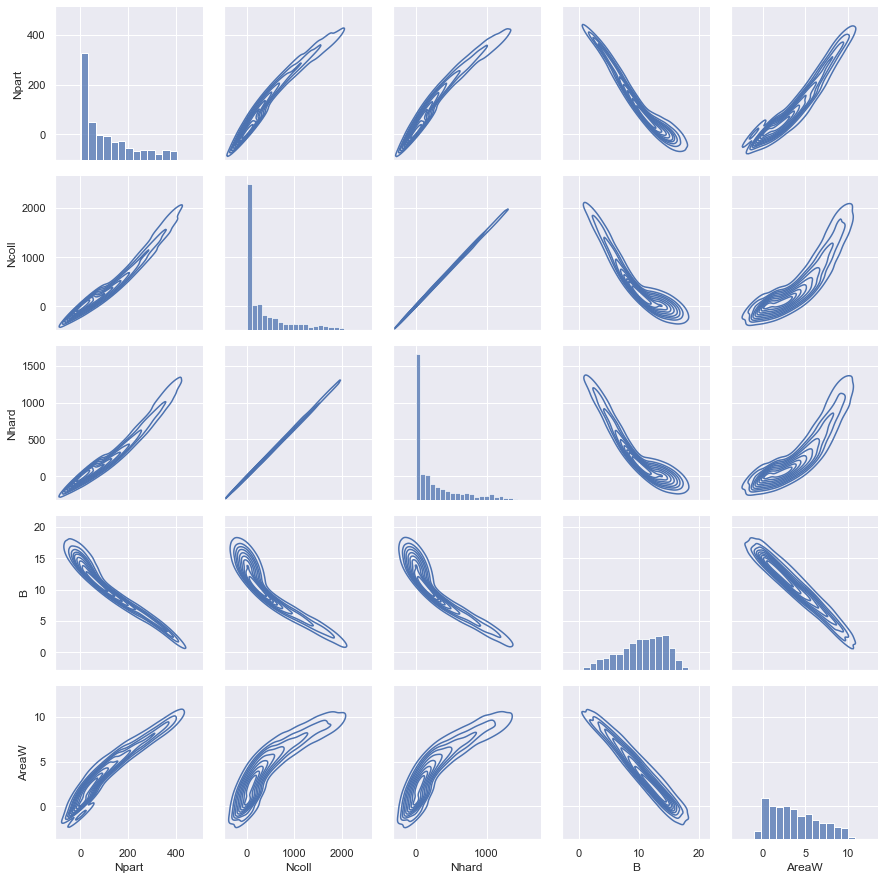

In [15]:
g = sns.PairGrid(gdf, vars=["Npart", "Ncoll", "Nhard", "B", "AreaW"])
g.map_diag(sns.histplot)
g.map_offdiag(sns.kdeplot)

In [8]:
def get_args_from_settings(ssettings):
    sys.argv=[' '] + ssettings.split()
    parser = argparse.ArgumentParser(description='pythia8 fastjet on the fly')
    pyconf.add_standard_pythia_args(parser)
    parser.add_argument('--output', default="test_ang_ue.root", type=str)
    parser.add_argument('--user-seed', help='pythia seed', default=1111, type=int)
    args = parser.parse_args()
    return args

In [9]:
mycfg = []
# ssettings = "--py-ecm 5000 --py-minbias --py-nsd --user-seed=100000"
# ssettings = "--py-ecm 5000 --py-nsd --user-seed=100000"
# ssettings = "--py-ecm 5000 --py-inel --user-seed=100000"
# ssettings = "--py-ecm 5000 --py-inel --py-noISR --user-seed=100000"
ssettings = "--py-ecm 5000 --py-inel --py-noue --user-seed=100000"
args = get_args_from_settings(ssettings)
pythia_mb = pyconf.create_and_init_pythia_from_args(args, mycfg)

['HardQCD:all=off', 'PromptPhoton:all=off', 'SoftQCD:all=off', 'SoftQCD:nonDiffractive=on', 'SoftQCD:inelastic=on', 'PhaseSpace:pTHatMin = -1', 'PartonLevel:ISR = off', 'PartonLevel:MPI = off', 'Beams:eCM = 5000.0']
[i] strings read to PYTHIA  [['HardQCD:all=off', 'PromptPhoton:all=off', 'SoftQCD:all=off', 'SoftQCD:nonDiffractive=on', 'SoftQCD:inelastic=on', 'PhaseSpace:pTHatMin = -1', 'PartonLevel:ISR = off', 'PartonLevel:MPI = off', 'Beams:eCM = 5000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']]
[i] pythia initialized with ['HardQCD:all=off', 'PromptPhoton:all=off', 'SoftQCD:all=off', 'SoftQCD:nonDiffractive=on', 'SoftQCD:inelastic=on', 'PhaseSpace:pTHatMin = -1', 'PartonLevel:ISR = off', 'PartonLevel:MPI = off', 'Beams:eCM = 5000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']

 *-------------

In [10]:
max_eta_hadron=1
parts_selector_h = fj.SelectorPtMin(0.15) & fj.SelectorAbsEtaMax(max_eta_hadron)
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
jet_area_def = fj.AreaDefinition(fj.active_area, fj.GhostedAreaSpec(max_eta_hadron))
jet_selector = fj.SelectorPtMin(1) & fj.SelectorAbsEtaMax(max_eta_hadron - 1.05 * jet_R0)

# estimate the background
grid_spacing = 0.25
gmbge = fj.GridMedianBackgroundEstimator(max_eta_hadron - 1.05 * jet_R0, grid_spacing)

In [11]:
# initialize the output
tw = treewriter.RTreeWriter(name = 'gpy', file_name = 'glauber_pythia_jets.root')

[i] new file glauber_pythia_jets.root


In [12]:
from tqdm.notebook import tqdm
#for ncoll in tqdm(gdf['Ncoll']):
for idx in tqdm(gdf.index):
    ncoll = gdf['Ncoll'][idx]
    # pinfo('idx', idx, 'ncoll', ncoll, 'npart', gdf['Npart'][idx], 'nhard', gdf['Nhard'][idx])
    # for ipymb in tqdm(range(int(ncoll))): # this gives a progress bar per glauber event... too many
    pp_events = [] # list of list of particles
    AA_event = None # list of particles
    # for ipymb in range(int(gdf['Nhard'][idx])):
    for ipymb in range(int(ncoll)):
        # try generating twice (ignore the first fail)
        if not pythia_mb.next():
            if not pythia_mb.next():
                pwarning("warning: event generation failed twice in a row?")
                continue
        # warn: for indexing assuming that it is unlikely to have more than 1k particles in |eta| < 1
        # parts_pythia_h_ue = pythiafjext.vectorize_select(pythia_mb, [pythiafjext.kFinal], ipymb * 1000, False)
        parts_pythia_h_ue = pythiafjext.vectorize_select(pythia_mb, [pythiafjext.kFinal, pythiafjext.kCharged], ipymb * 1000, False)
        if parts_pythia_h_ue.size() > 1000:
            pwarning('warning: more than 1k particles selected', parts_pythia_h_ue.size())
        parts_pythia_h_selected_ue = parts_selector_h(parts_pythia_h_ue)
        if AA_event is None:
            AA_event = [psj for psj in parts_pythia_h_selected_ue]
        else:
            _ = [AA_event.append(psj) for psj in parts_pythia_h_selected_ue]
        pp_events.append(parts_pythia_h_selected_ue)
    
    # jet finding for each pp event
    pp_jets = []
    cs_pps = [] # needed for scoping of area
    for pp_event in pp_events:
        cs_pp = fj.ClusterSequenceArea(pp_event, jet_def, jet_area_def)
        _pp_jets = jet_selector(cs_pp.inclusive_jets())
        _ = [pp_jets.append(j) for j in _pp_jets]
        cs_pps.append(cs_pp)

    # jet finding for the AA event
    cs_AA = fj.ClusterSequenceArea(AA_event, jet_def, jet_area_def)
    AA_jets = jet_selector(cs_AA.inclusive_jets())

    gmbge.set_particles(AA_event)
    rho = gmbge.rho()
    sigma = gmbge.sigma()
    # pinfo('rho =', rho, 'sigma of rho =', sigma)
    
    # fill the output
    tw.fill_branches(jAA = AA_jets, 
                     jAAsub_pt = [j.perp() - rho * j.area() for j in AA_jets],
                     AAmult = len(AA_event),
                     rho = rho,
                     sigma = sigma,
                     jpp = pp_jets,
                     AAparts = AA_event)
    tw.fill_tree()
tw.write_and_close()

  0%|          | 0/1000 [00:00<?, ?it/s]

[i] RTreeWriter gpy tree tgpy: creating branch [jAA_pt]
[i] RTreeWriter gpy tree tgpy: creating branch [jAA_phi]
[i] RTreeWriter gpy tree tgpy: creating branch [jAA_eta]
[i] RTreeWriter gpy tree tgpy: creating branch [jAA_m]
[i] RTreeWriter gpy tree tgpy: creating branch [jAA_a]
[i] RTreeWriter gpy tree tgpy: creating branch [jAA_nconst]
[i] RTreeWriter gpy tree tgpy: creating branch [jAAsub_pt]
[i] RTreeWriter gpy tree tgpy: creating branch [AAmult]
[i] RTreeWriter gpy tree tgpy: creating branch [rho]
[i] RTreeWriter gpy tree tgpy: creating branch [sigma]
[i] RTreeWriter gpy tree tgpy: creating branch [jpp_pt]
[i] RTreeWriter gpy tree tgpy: creating branch [jpp_phi]
[i] RTreeWriter gpy tree tgpy: creating branch [jpp_eta]
[i] RTreeWriter gpy tree tgpy: creating branch [jpp_m]
[i] RTreeWriter gpy tree tgpy: creating branch [jpp_a]
[i] RTreeWriter gpy tree tgpy: creating branch [jpp_nconst]
[i] RTreeWriter gpy tree tgpy: creating branch [AAparts_pt]
[i] RTreeWriter gpy tree tgpy: creati

In [16]:
pythia_mb.stat()


 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | non-diffractive                                101 |      268789     268789     268789 |   4.769e+01  0.000e+00 |
 | A B -> X B single diffractive                  103 |       3

In [17]:
ccount = 0

In [31]:
def draw(t, what, extraopt):
    global ccount
    # cname = 'tcanvas_{}'.format(ccount)
    cname = 'tcanvas_{}_{}'.format(str(what), extraopt)
    for cx in [' ', '&', '>', '<', '.', '[', ']', '\'', ',', '(', ')']:
        cname = cname.replace(cx, '_')    
    tc = ROOT.TCanvas(cname, cname)
    tc.cd()
    hists = []
    tc.Draw()
    maxy = -1e10
    miny = 1e10
    ytitle = ''
    xtitle = ''
    extraopt = extraopt.replace('xdivx', '/')
    if 'ytitle=' in extraopt:
        ytitle = extraopt.split('ytitle=')[1].split(',,')[0]
    if 'xtitle=' in extraopt:
        xtitle = extraopt.split('xtitle=')[1].split(',,')[0]
    if 'opstat=' in extraopt:
        ROOT.gStyle.SetOptStat(int(extraopt.split('opstat=')[1].split(' ')[0]))
    for i,w in enumerate(what):
        same = ''
        if '(' in w[0]:
            svar = w[0].split('(')[0]
            binning = w[0].split('(')[1].split(')')[0]
            hname = "htmp_{}_{}".format(cname, svar+w[1])
            _sdraw = "{}>>{}({})".format(svar,hname,binning)
            #print(_sdraw)
            t.Draw(_sdraw, w[1])
            w[0] = svar
        else:
            hname = "htmp_{}_{}".format(cname, w[0]+w[1])
            t.Draw("{}>>{}".format(w[0],hname), w[1])
        h = ROOT.gDirectory.Get(hname)
        if '+dn' in extraopt:
            h.Sumw2()
            h.Scale(1./h.GetBinWidth(1))
        if 'miny=' in extraopt:
            lowy=extraopt.split('miny=')[1].split(' ')[0]
            miny = float(lowy)
        else:
            if miny < h.GetMinimum():
                miny = h.GetMinimum() * 0.9
        if 'maxy=' in extraopt:
            highy=extraopt.split('maxy=')[1].split(' ')[0]
            maxy = float(highy)
        else:
            if maxy < h.GetMaximum():
                maxy = h.GetMaximum() * 1.1
        hists.append(h)
    for i,w in enumerate(what):
        xopt = w[2] + ' '
        if "+k" in xopt:
            _s = xopt.split('+k')[1].split(' ')[0]
            col = int(_s)
            w[2] = w[2].replace('+k'+_s, '')
            hists[i].SetLineColor(col)
        if "+l" in xopt:
            _s = xopt.split('+l')[1].split(' ')[0]
            lstyle = int(_s)
            hists[i].SetLineStyle(lstyle)
            w[2] = w[2].replace('+l'+_s, '')
        w[2] = w[2].strip()
        print(i, w, hists[i].GetEntries(), hists[i].Integral())
        hists[i].GetXaxis().SetTitle(xtitle)
        hists[i].GetYaxis().SetTitle(ytitle)
        if '+t=' in xopt:
            _stitle = xopt.split('+t=')[1].split(',,')[0]
            hists[i].SetTitle(_stitle)
            w[2] = w[2].replace('+t={},,'.format(_stitle), '')
        if i > 0:
            if 'same' not in w[2]:
                if len(w[2]) > 0:
                    w[2] = w[2] + ' same'
                else:
                    w[2] = 'same'
        hists[i].Draw(w[2])
    if 'xrange=' in extraopt:
        lowx=extraopt.split('xrange=')[1].split(',')[0]
        highx=extraopt.split('xrange=')[1].split(',')[1].split(' ')[0]
        _ht = ROOT.TH1F('_ht_{}'.format(ccount), ' ', 10, int(lowx), int(highx))
        _ht.SetMaximum(maxy)
        _ht.SetMinimum(miny)
        _ht.GetXaxis().SetTitle(xtitle)
        _ht.GetYaxis().SetTitle(ytitle)
        _ht.SetLineColor(0)
        hists.append(_ht)
        _ht.Draw()
        for i,w in enumerate(what):
            if 'same' not in w[2]:
                if len(w[2]) > 0:
                    w[2] = w[2] + ' same'
                else:
                    w[2] = 'same'
            hists[i].Draw(w[2])
    if '+logz' in extraopt:
        ROOT.gPad.SetLogz()
    if '+logx' in extraopt:
        ROOT.gPad.SetLogx()
    if '+logy' in extraopt:
        ROOT.gPad.SetLogy()
    if '+gridx' in extraopt:
        ROOT.gPad.SetGridx()
    if '+gridy' in extraopt:
        ROOT.gPad.SetGridy()
    if '+legend' in extraopt:
        _leg = ROOT.gPad.BuildLegend()
        _leg.SetLineStyle(ROOT.kWhite)
        _leg.SetLineWidth(0)
        _leg.SetFillColorAlpha(ROOT.kWhite, 0.5)
    tc.Draw()
    ccount = ccount + 1
    return tc, hists

0 ['rho:AAmult', '', 'colz'] 1000.0 1000.0


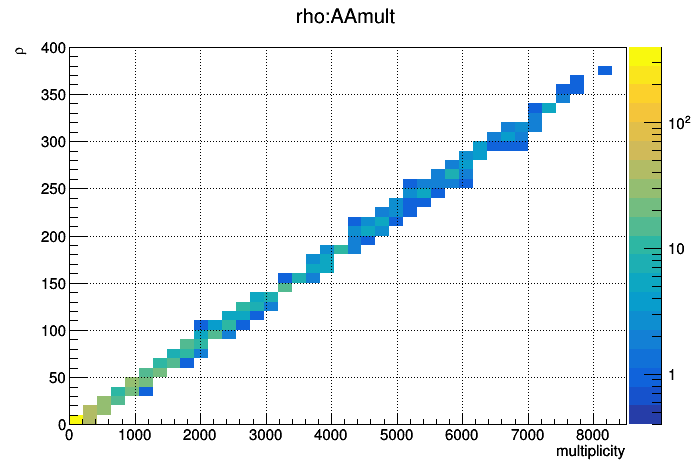

In [22]:
f = ROOT.TFile("glauber_pythia_jets.root")
t = f.Get("tgpy")
tc = draw(t, [['rho:AAmult', '', 'colz']], '+logz +gridx +gridy xtitle=multiplicity,, ytitle=#rho,, opstat=0')

0 ['jpp_pt', '', 'hist  +t=pp jets,,'] 84705.0 84704.0
1 ['jAAsub_pt', '', 'hist same  +t=AA jets p_{T} - #rho x A,,'] 13082.0 13075.0
2 ['jAAsub_pt', 'jAA_a>0.2', 'hist same   +t=AA jets with A>0.2,,'] 9729.0 9722.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: tcanvas____jpp_pt_50_0_50_________hist_+k1_+t=pp_jets________jAAsub_pt_100_-50_50_________hist_same_+k2_+t=AA_jets_p_{T}_-_#rho_x_A________jAAsub_pt_100_-50_50_____jAA_a_0_2____hist_same_+k4_+l2_+t=AA_jets_with_A_0_2______opstat=0_+logy_+gridx_+gridy_+legend_xrange=-30_50_+dn_maxy=2e5_miny=1_xtitle=p_{T}___ytitle=dNxdivxdp_{T}__


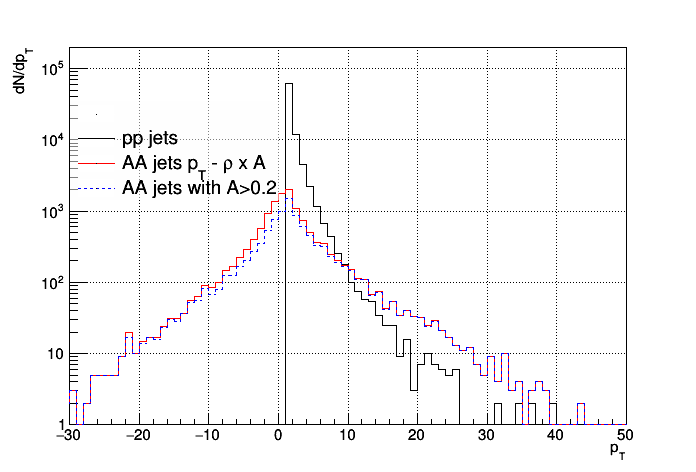

In [32]:
tc = draw(t, 
          [
            ['jpp_pt(50,0,50)', '', 'hist +k1 +t=pp jets,,'], 
            ['jAAsub_pt(100,-50,50)', '', 'hist same +k2 +t=AA jets p_{T} - #rho x A,,'], 
            ['jAAsub_pt(100,-50,50)', 'jAA_a>0.2', 'hist same +k4 +l2 +t=AA jets with A>0.2,,']
          ], 
          'opstat=0 +logy +gridx +gridy +legend xrange=-30,50 +dn maxy=2e5 miny=1 xtitle=p_{T},, ytitle=dNxdivxdp_{T},,')

0 ['jpp_a', '', 'hist  +t=pp jets,,'] 84705.0 8470500.0
1 ['jAA_a', '', 'hist  +t=AA jets,,'] 13082.0 1308200.0


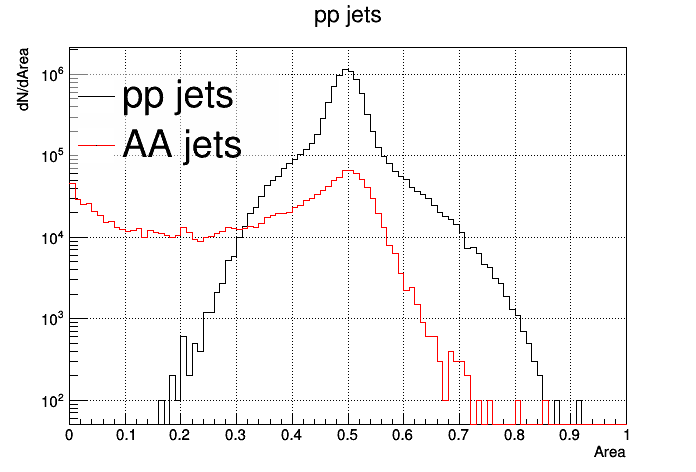

In [24]:
tc = draw(t, 
        [
            ['jpp_a(100,0,1)', '', 'hist +k1 +t=pp jets,,'],
            ['jAA_a(100,0,1)', '', 'hist +k2 +t=AA jets,,']          
        ],
          '+logy +gridx +gridy +legend +dn +xtitle=Area,, +ytitle=dNxdivxdArea')